In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Desativando avisos do TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



2024-11-14 17:05:13.445595: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 17:05:13.453751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 17:05:13.462437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 17:05:13.465210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 17:05:13.472783: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Limtiando uso de GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=9000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f'{len(gpus)} GPU física disponível, {len(logical_gpus)} GPU lógica configurada.')
    except RuntimeError as e:
        print(e)

1 GPU física disponível, 1 GPU lógica configurada.


I0000 00:00:1731614714.734956 2232216 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731614714.763249 2232216 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731614714.763397 2232216 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731614714.765198 2232216 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
# Carregando os dados
(train_images, train_labels), _  = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
# Adicionando uma dimensão extra
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalizando imagens
train_images = (train_images - 127.5)/127.5

In [5]:
# Adicionando batches
batch_size = 256

# Embaralhando os dados de treino e fazendo o batching em um dataset `ds`
train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)


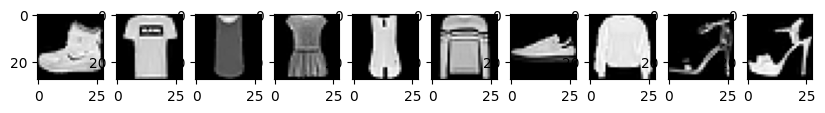

In [6]:
# Visualizando imagens
num_images_show = 10

plt.figure(figsize=(10,10))

for i in range(num_images_show):
    plt.subplot(1,num_images_show, i+1)
    plt.imshow(train_images[i].reshape(28,28), cmap = 'gray') # Redimensionando para tam original
    
plt.show()

## Estruturando um gerador de imagens
Usaremos um modelo que segue um diffusion, começaremos de um ruído e o modelo irá trabalhar com base em uma entrada

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
def constroi_gerador():
    modelo = Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(7*7*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5),
                               strides=(1, 1),
                               padding='same',
                               use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False,
                               activation='tanh')
    ])
    
    return modelo

In [9]:
gerador = constroi_gerador()

In [10]:
# Processando dados de ruído
dim_ruido = 100
ruido = tf.random.normal([1, dim_ruido])

2024-11-14 17:05:16.032784: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1731614716.068691 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.085968 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.086531 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.087859 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.088120 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.088330 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.088589 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.088832 2232216 gpu_t

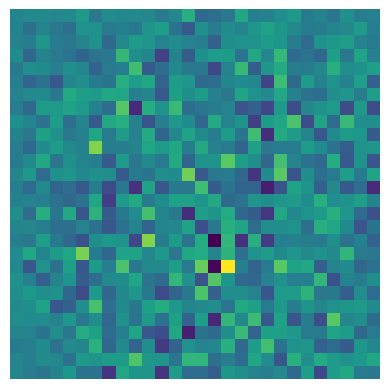

In [11]:
# Fazendo um teste passando o ruído pela rede cru
imagem_gerada = gerador(ruido, training=False)

# Visualizando a imagem
plt.imshow((imagem_gerada[0]*127.5+127.5).numpy()) # Desnormalizando as imagens
plt.axis('off')
plt.show()

In [12]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

## Rede Discriminadora
Temos que criar uma rede para pegar as imagens geradas e identificar se elas são imagens reais ou não. O objetivo é fazer a rede geradora enganar a discriminadora

In [13]:
def constroi_discriminador():
    modelo = Sequential([
        layers.Input(shape=(28,28,1)),

        layers.Conv2D(64,(5,5), strides=(2,2), padding = 'same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128,(5,5), strides=(2,2), padding = 'same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return modelo

In [14]:
# Analisando a minha rede discriminadora
discriminador = constroi_discriminador()
decisao = discriminador(imagem_gerada)
print(decisao) # A saída será uma saída 0 para falsa e 1 para verdadeira

W0000 00:00:1731614716.217318 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.218860 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.219041 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.219382 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.219970 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.220167 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.221014 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.221199 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.221375 2232216 gp

tf.Tensor([[0.00180172]], shape=(1, 1), dtype=float32)


W0000 00:00:1731614716.233534 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.233789 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.234790 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.235716 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.236524 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.236746 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.244306 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.244522 2232216 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731614716.244716 2232216 gp

In [15]:
# Definindo funções custo
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True) # Parâmetro compensa a falta de ativação na saída

In [16]:
def custo_discriminador(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def custo_gerador(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
otimizador_gerador = tf.keras.optimizers.Adam(1e-4)
otimizador_discriminador = tf.keras.optimizers.Adam(1e-4)

In [19]:
checkpoint_path = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_path, 'ckpt')

checkpoint = tf.train.Checkpoint(generator_optimizer = otimizador_gerador,
                                 discriminador_optimizer = otimizador_discriminador,
                                 generator = gerador,
                                 discriminador = discriminador)

In [20]:
# Definindo um loop de treinamento
epochs = 50
dim_ruido = 100
num_exemplos_treinamento = 16

seed = tf.random.normal([num_exemplos_treinamento, dim_ruido])

In [21]:
# Passos do treinamento
@tf.function
def passo_treino(images):
    ruido = tf.random.normal([batch_size, dim_ruido])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gerador(ruido, training=True)

        real_output = discriminador(images, training=True)
        fake_output = discriminador(generated_images, training=True)

        gen_loss = custo_gerador(fake_output)
        disc_loss = custo_discriminador(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

    otimizador_gerador.apply_gradients(zip(gradients_of_generator, gerador.trainable_variables))
    otimizador_discriminador.apply_gradients(zip(gradients_of_discriminator, discriminador.trainable_variables))

In [22]:
import time
from IPython.display import clear_output

In [23]:
def gera_e_salva_imagens(modelo, epoca, entrada):
  # Observe que `training` está definido como False.
  # Isso é para que todas as camadas sejam executadas no modo de inferência (batchnorm).
  previsao = modelo(entrada, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(previsao.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(previsao[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoca))
  plt.show()
     

In [24]:
def treino(dataset, epocas):
    for epoca in range(epocas):
        start = time.time()

        for image_batch in dataset:
           passo_treino(image_batch)

        # Produz as imagens para gerar um gif
        clear_output(wait=True)
        gera_e_salva_imagens(gerador,
                                 epoca + 1,
                                 seed)

        # Salva o modelo a cada 15 épocas
        if (epoca + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Tempo por época {} é {} s'.format(epoca + 1, time.time()-start))

    # Gera após a época final
    clear_output(wait=True)
    gera_e_salva_imagens(gerador,
                                 epoca + 1,
                                 seed)

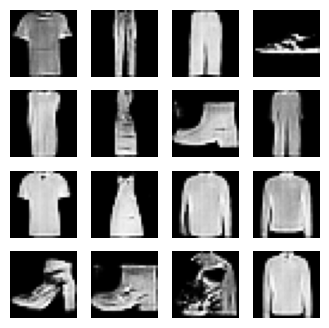

In [25]:
# Aplicando o treinamento
treino(train_ds, epocas=1200)